In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
import scipy.io
import matplotlib.pyplot as plt

In [3]:
# Load the .mat file
data = scipy.io.loadmat('channel_data.mat')

# Assuming the data is stored under key 'X' in the .mat file
channel_data = data['channel']  # Shape (10000, 2), with real and imaginary parts
print("Channel data shape:", channel_data.shape)

# Prepare sliding windows of 5 inputs to predict the next value
def create_dataset(data, input_size=5):
    X, y = [], []
    for i in range(len(data) - input_size):
        X.append(data[i:i + input_size])  # Input: 5 timesteps
        y.append(data[i + input_size])   # Output: next value
    return np.array(X), np.array(y)

input_size = 5
X, y = create_dataset(channel_data, input_size)


Channel data shape: (10000, 2)


In [4]:
# Split into training and testing sets
split_index = int(0.7 * len(X))  # 70% training, 30% testing
train_data, test_data = X[:split_index], X[split_index:]
train_labels, test_labels = y[:split_index], y[split_index:]

# Reshape for LSTM: (samples, timesteps, features)
train_data = train_data.reshape(train_data.shape[0], input_size, 2)
test_data = test_data.reshape(test_data.shape[0], input_size, 2)


In [5]:
print(train_data.shape)
print(test_data.shape)

(6996, 5, 2)
(2999, 5, 2)


In [6]:
# Split labels into real and imaginary parts
train_labels_real = train_labels[:, 0]
train_labels_imag = train_labels[:, 1]
test_labels_real = test_labels[:, 0]
test_labels_imag = test_labels[:, 1]

In [8]:
model = Sequential([
    tf.keras.layers.InputLayer(input_shape=(5, 2)),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(2)  # Output layer for real and imaginary parts
])


'''
請完成 model.compile，選好optimizer & loss function
請完成 model.fit，設定好input data & labels, epochs, batch_size, validation_data
'''
# Compile the model
model.compile(
    optimizer='adam',  # Optimizer
    loss='mean_squared_error',  # Loss function
    metrics=['accuracy']  # Metric to monitor
)

# Train the model
history = model.fit(
    train_data,  # Input data
    np.column_stack((train_labels_real, train_labels_imag)),  # Labels (real and imaginary parts)
    epochs=10,  # Number of epochs
    batch_size=32,  # Batch size
    validation_data=(test_data, np.column_stack((test_labels_real, test_labels_imag)))  # Validation data
)

Epoch 1/10
219/219 [==============================] - 2s 6ms/step - loss: 0.0308 - accuracy: 0.9728 - val_loss: 3.6422e-04 - val_accuracy: 0.9917
Epoch 2/10
219/219 [==============================] - 1s 4ms/step - loss: 4.1596e-04 - accuracy: 0.9946 - val_loss: 1.3635e-04 - val_accuracy: 0.9940
Epoch 3/10
219/219 [==============================] - 1s 4ms/step - loss: 1.8642e-04 - accuracy: 0.9946 - val_loss: 8.8024e-05 - val_accuracy: 0.9963
Epoch 4/10
219/219 [==============================] - 1s 4ms/step - loss: 1.1607e-04 - accuracy: 0.9949 - val_loss: 5.0975e-05 - val_accuracy: 0.9963
Epoch 5/10
219/219 [==============================] - 1s 4ms/step - loss: 9.8058e-05 - accuracy: 0.9949 - val_loss: 4.3567e-05 - val_accuracy: 0.9913
Epoch 6/10
219/219 [==============================] - 1s 4ms/step - loss: 9.3122e-05 - accuracy: 0.9946 - val_loss: 4.3194e-05 - val_accuracy: 0.9910
Epoch 7/10
219/219 [==============================] - 1s 4ms/step - loss: 9.1019e-05 - accuracy: 0.9953 

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                17152     
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 17,282
Trainable params: 17,282
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_data, test_labels)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Predict on the test data
predictions = model.predict(test_data)

# Extract real and imaginary predictions
predictions_real = predictions[:, 0]
predictions_imag = predictions[:, 1]

94/94 [==============================] - 0s 4ms/step - loss: 4.6793e-05 - accuracy: 0.9923
Test Accuracy: 0.99
94/94 [==============================] - 0s 2ms/step


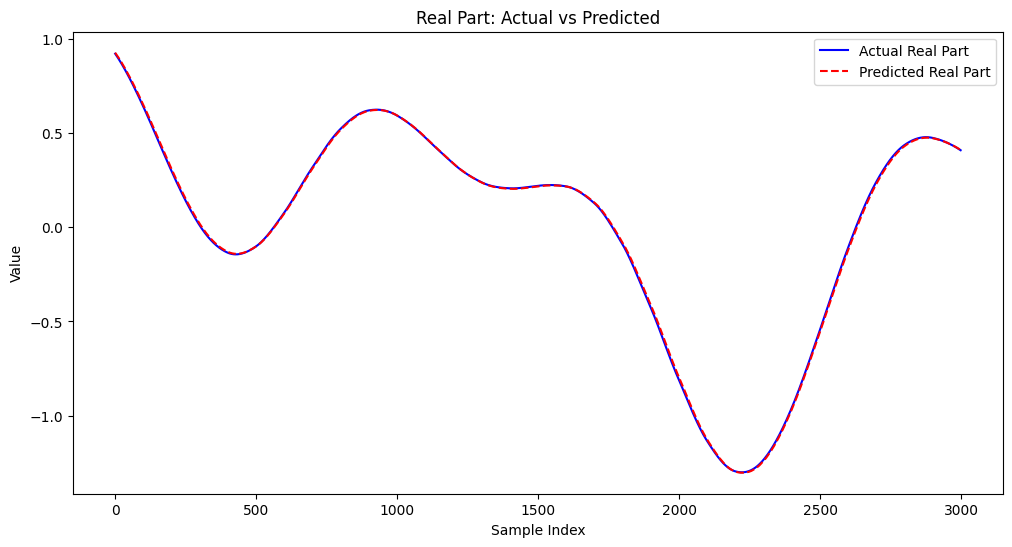

In [11]:
# Plot real part
plt.figure(figsize=(12, 6))
plt.plot(range(len(test_labels_real)), test_labels_real, label='Actual Real Part', color='blue')
plt.plot(range(len(predictions_real)), predictions_real, label='Predicted Real Part', color='red', linestyle='--')
plt.title('Real Part: Actual vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()

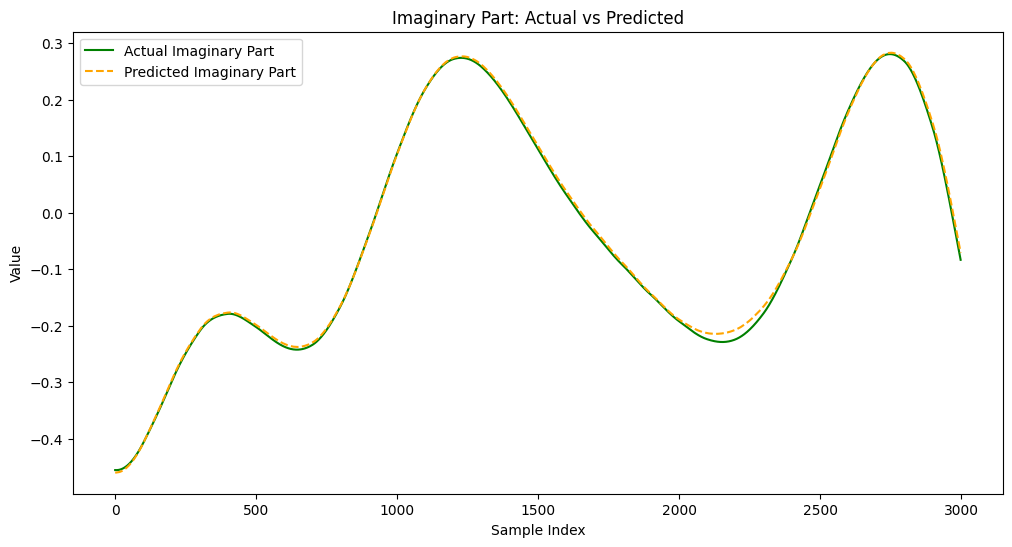

In [12]:
# Plot imaginary part
plt.figure(figsize=(12, 6))
plt.plot(range(len(test_labels_imag)), test_labels_imag, label='Actual Imaginary Part', color='green')
plt.plot(range(len(predictions_imag)), predictions_imag, label='Predicted Imaginary Part', color='orange', linestyle='--')
plt.title('Imaginary Part: Actual vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()